In [1]:
import pandas as pd
from preprocessing import resample_data, create_target
import warnings
from catboost import CatBoostClassifier, Pool
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("/home/kenny/algohub/data/data_eth_2018_2024.csv")

In [3]:
data['Time'] = pd.to_datetime(data['Time'])
data = data.set_index("Time")

In [4]:
time_frames = [15, 30, 60, 240, 1440]
new_data = resample_data(data, time_frames)

In [5]:
new_data.head(15)

,Open,High,Low,Close,Volume,Open_15min,High_15min,Low_15min,Close_15min,Volume_15min,...,Open_240min,High_240min,Low_240min,Close_240min,Volume_240min,Open_1440min,High_1440min,Low_1440min,Close_1440min,Volume_1440min
Time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,733.01,734.52,728.93,728.93,133.48778,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:05:00,728.50,729.80,724.43,727.25,134.91765,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:10:00,727.26,727.31,722.91,727.31,152.44187,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:15:00,727.22,728.44,723.00,724.99,144.34597,733.01,734.52,722.91,727.31,420.84730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:20:00,724.99,725.00,722.91,723.03,130.56056,733.01,734.52,722.91,727.31,420.84730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:25:00,723.00,726.99,720.03,725.51,311.97905,733.01,734.52,722.91,727.31,420.84730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:30:00,725.51,727.99,724.44,727.54,179.85710,727.22,728.44,720.03,725.51,586.88558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:35:00,727.54,728.61,725.62,727.45,227.37557,727.22,728.44,720.03,725.51,586.88558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:40:00,725.99,727.18,722.85,723.38,114.88645,727.22,728.44,720.03,725.51,586.88558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
new_data.isna().sum().sum()

1785

In [7]:
new_data.dropna(inplace=True)

In [8]:
new_data.isna().sum().sum()

0

In [9]:
new_data = create_target(new_data, size=1500, future_time=10)

In [10]:
new_data["Target"] += 1

In [11]:
new_data["Target"].value_counts()

Target
1    342208
2    148280
0    146031
Name: count, dtype: int64

### Model training

In [12]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, log_loss
from optuna.trial import Trial
import numpy as np
import optuna

In [13]:
def objective(trial: Trial, df: pd.DataFrame, features: list[str], number_of_splits: int = 5):
    tss = TimeSeriesSplit(n_splits=number_of_splits)
    df = df.sort_index()

    params = {
        'device': 'gpu',
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': 3,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'verbose': -1,
    }

    # predictions = []
    scores = []

    for train_idx, test_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[test_idx]

        X_train = train[features]
        y_train = train['Target']

        X_test = test[features]
        y_test = test['Target']

        model = lgb.train(params,
                      lgb.Dataset(X_train, label=y_train),
                      valid_sets=lgb.Dataset(X_test, label=y_test))

        y_pred = model.predict(X_test)
        scores.append(log_loss(y_test, y_pred))

    return np.mean(scores)


TypeError: 'type' object is not subscriptable

In [ ]:
def objective():
    params = {
        "eval_metric": "AUC",
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.2),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10),
        "iterations": trial.suggest_int("iterations", 800, 1500, 100),
        "random_strength": trial.suggest_float("random_strength", 1e-2, 1.0),
        "depth": trial.suggest_int("depth", 6, 12),
        "bootstrap_type": "Bayesian",
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 10),
    }

    train_pool = Pool(
        data=df_train.drop([target], axis=1),
        cat_features=cat_features,
        label=df_train[target],
        text_features=text_features,
    )
    val_pool = Pool(
        data=df_val.drop([target], axis=1),
        cat_features=cat_features,
        label=df_val[target],
        text_features=text_features,
    )

    gbm = CatBoostClassifier(**params)
    gbm.fit(train_pool, eval_set=val_pool, verbose=200)

    y_val_pred = gbm.predict_proba(val_pool)[:, 1]
    return roc_auc_score(df_val[target], y_val_pred)

In [ ]:
begin_date = pd.to_datetime("2018-01-01T00:00:00")
end_date = pd.to_datetime("2023-01-01T00:00:00")

new_data_train = new_data[(new_data.index <= end_date)].copy()
new_data_test = new_data[(new_data.index > end_date)].copy()

In [ ]:
features = list(set(new_data.columns) - set(["Target"]))

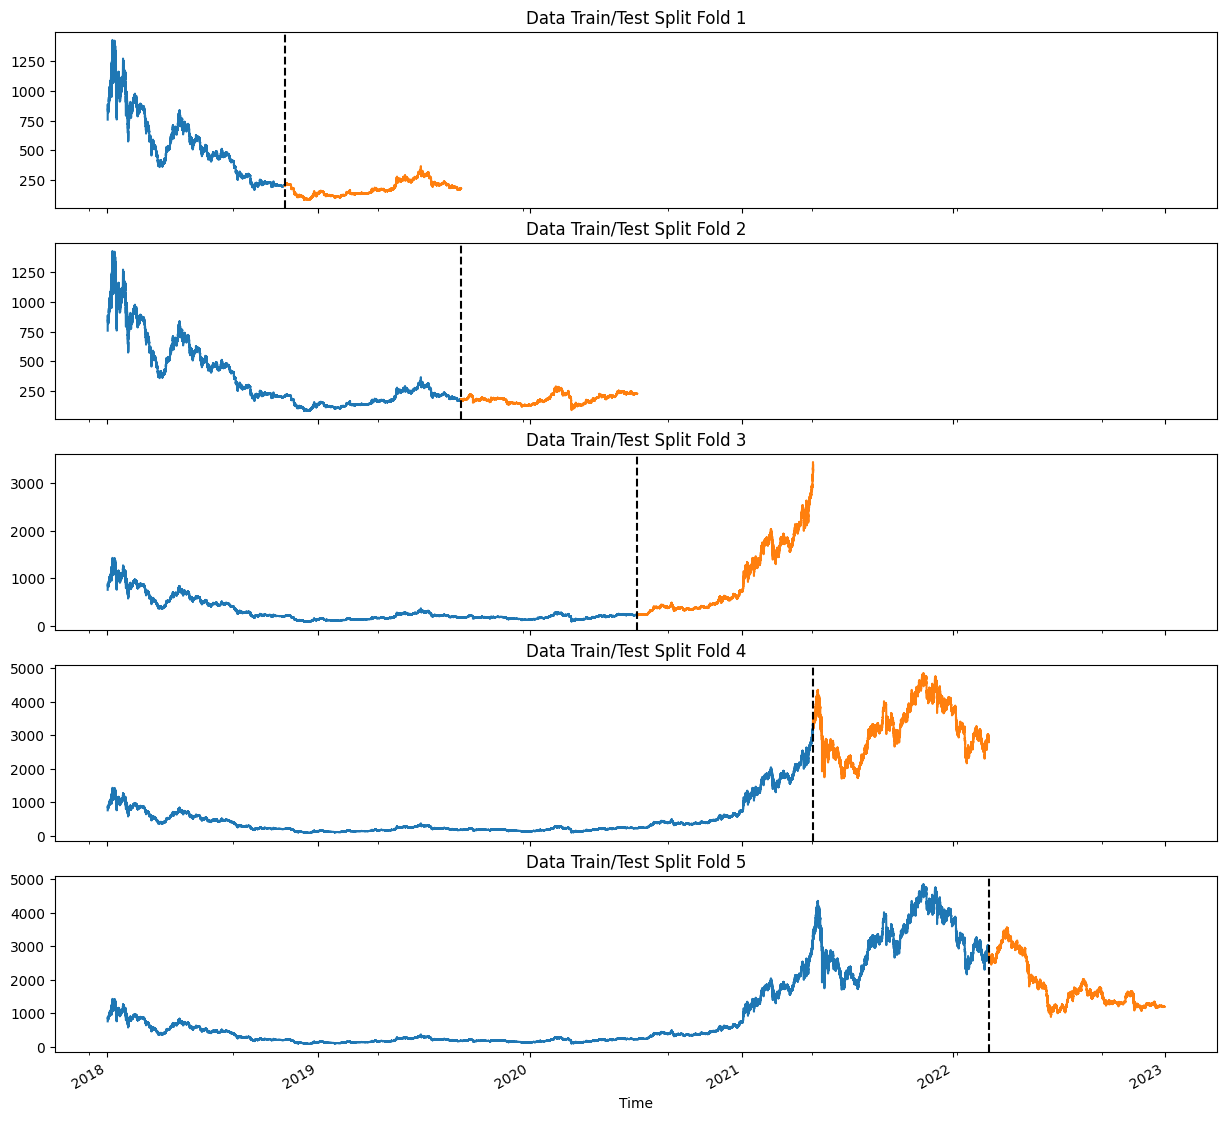

In [17]:
import matplotlib.pyplot as plt
tss = TimeSeriesSplit(n_splits=5)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True, )
fold = 0

for train_idx, val_idx in tss.split(new_data_train):
    train = new_data_train.iloc[train_idx]
    test = new_data_train.iloc[val_idx]
    train['Close'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold + 1}')
    test['Close'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [18]:
# study = optuna.create_study(direction='minimize')
# func = lambda trial: objective(trial, new_data_train, features)
# study.optimize(func, n_trials=100)

In [23]:
params = {
    'device': 'gpu',
    'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': 3,  # Replace with the number of classes in your dataset
        'boosting_type': 'gbdt',
        'verbose': -1,
    'lambda_l1': 6.236681610303478e-05, 'lambda_l2': 0.00011326471313602211, 'num_leaves': 9, 'feature_fraction': 0.722170332541165}

In [19]:
X_train = new_data_train[features]
y_train = new_data_train['Target']

X_test = new_data_test[features]
y_test = new_data_test['Target']

train_pool = Pool(
    data=X_train,
    cat_features=[],
    label=y_train,
    text_features=[],
)
# val_pool = Pool(
#     data=df_val.drop([target], axis=1),
#     cat_features=cat_features,
#     label=df_val[target],
#     text_features=text_features,
# )

# model = lgb.train(params,
#                 lgb.Dataset(X_train, label=y_train),
#                 valid_sets=lgb.Dataset(X_test, label=y_test))

# model = lgb.Booster(model_file='lgb_model.txt')

cb_model = CatBoostClassifier()
cb_model.fit(train_pool, verbose=200)

# y_pred = model.predict(X_test)

Learning rate set to 0.108895
0:	learn: 1.0184214	total: 141ms	remaining: 2m 21s
200:	learn: 0.6690493	total: 15.7s	remaining: 1m 2s
400:	learn: 0.6635342	total: 30.8s	remaining: 46s
600:	learn: 0.6596557	total: 48.4s	remaining: 32.2s
800:	learn: 0.6562502	total: 1m 6s	remaining: 16.5s
999:	learn: 0.6529395	total: 1m 24s	remaining: 0us


In [20]:
y_pred = cb_model.predict(X_test)

In [21]:
y_pred

array([[1],
       [1],
       [1],
       ...,
       [2],
       [2],
       [2]])

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.30      0.40      0.34     31242
           1       0.58      0.49      0.53     49326
           2       0.35      0.32      0.34     31945

    accuracy                           0.42    112513
   macro avg       0.41      0.40      0.40    112513
weighted avg       0.44      0.42      0.42    112513



In [21]:
print(classification_report(y_test, np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.28      1.00      0.44     31242
           1       0.25      0.00      0.00     49326
           2       0.11      0.00      0.00     31945

    accuracy                           0.28    112513
   macro avg       0.21      0.33      0.15    112513
weighted avg       0.22      0.28      0.12    112513



In [23]:
# new_data_test["Predictions"] = np.argmax(y_pred, axis=1)
new_data_test["Predictions"] = y_pred

In [24]:
begin_date = pd.to_datetime("2024-01-23T00:00:00")
template = new_data_test[new_data_test.index>=begin_date].copy()
template

,Open,High,Low,Close,Volume,Open_15min,High_15min,Low_15min,Close_15min,Volume_15min,...,Low_240min,Close_240min,Volume_240min,Open_1440min,High_1440min,Low_1440min,Close_1440min,Volume_1440min,Target,Predictions
Time,,,,,,,,,,,,,,,,,,,,,
2024-01-23 00:00:00,2314.19,2319.60,2312.67,2318.20,2111.3548,2314.69,2317.53,2310.21,2314.20,5510.5777,...,2303.59,2314.2,81266.0662,2457.06,2466.10,2303.59,2314.20,526337.6492,2,0
2024-01-23 00:05:00,2318.19,2324.65,2317.06,2324.38,4234.1497,2314.69,2317.53,2310.21,2314.20,5510.5777,...,2303.59,2314.2,81266.0662,2457.06,2466.10,2303.59,2314.20,526337.6492,2,0
2024-01-23 00:10:00,2324.38,2325.39,2319.03,2322.64,1272.6943,2314.69,2317.53,2310.21,2314.20,5510.5777,...,2303.59,2314.2,81266.0662,2457.06,2466.10,2303.59,2314.20,526337.6492,2,2
2024-01-23 00:15:00,2322.65,2327.11,2321.85,2326.12,1211.0385,2314.19,2325.39,2312.67,2322.64,7618.1988,...,2303.59,2314.2,81266.0662,2457.06,2466.10,2303.59,2314.20,526337.6492,1,0
2024-01-23 00:20:00,2326.11,2327.62,2324.46,2324.80,927.3362,2314.19,2325.39,2312.67,2322.64,7618.1988,...,2303.59,2314.2,81266.0662,2457.06,2466.10,2303.59,2314.20,526337.6492,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-26 17:05:00,2279.86,2279.86,2275.00,2275.50,2430.7836,2270.88,2281.88,2269.11,2279.55,8583.4797,...,2234.46,2257.9,71448.4567,2235.02,2242.89,2171.30,2218.64,330426.6061,0,2
2024-01-26 17:10:00,2275.49,2276.69,2273.27,2273.68,2095.0957,2270.88,2281.88,2269.11,2279.55,8583.4797,...,2234.46,2257.9,71448.4567,2235.02,2242.89,2171.30,2218.64,330426.6061,0,2
2024-01-26 17:15:00,2273.69,2276.53,2271.82,2273.11,1503.6535,2279.55,2282.36,2273.27,2273.68,6643.3847,...,2234.46,2257.9,71448.4567,2235.02,2242.89,2171.30,2218.64,330426.6061,0,2


In [25]:
# template["Predictions"] = np.argmax(model.predict(template[features]), axis=1)
template["Predictions"] = cb_model.predict(template[features])

In [32]:
from strategies import Simple
from backtesting import Backtest


artisanal_lightgbm = Backtest(new_data_test[features + ["Predictions"]], Simple, cash=5000, commission=.0004, margin=1)
output = artisanal_lightgbm.run()
output

Start                     2023-01-01 00:05:00
End                       2024-01-26 17:25:00
Duration                    390 days 17:20:00
Exposure Time [%]                         0.0
Equity Final [$]                       5000.0
Equity Peak [$]                        5000.0
Return [%]                                0.0
Buy & Hold Return [%]               89.724606
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

In [33]:
artisanal_lightgbm.plot(resample=False)

GridPlot(id='p2427', ...)

In [25]:
top_secret = pd.read_csv("/Users/arsenchik/Desktop/projects/algohub/data/data_eth_top_secret.csv")

In [26]:
top_secret["Time"] = pd.to_datetime(top_secret["Time"])
top_secret = top_secret.set_index("Time")
top_secret

,Open,High,Low,Close,Volume
Time,,,,,
2024-01-27 00:00:00,2267.67,2268.93,2265.23,2266.40,1067.3254
2024-01-27 00:05:00,2266.40,2270.35,2266.40,2270.03,586.8083
2024-01-27 00:10:00,2270.03,2273.22,2270.03,2273.08,1120.6878
2024-01-27 00:15:00,2273.07,2273.81,2271.11,2271.59,654.3381
2024-01-27 00:20:00,2271.59,2273.31,2270.09,2270.80,1093.5429
...,...,...,...,...,...
2024-01-28 18:00:00,2269.28,2269.92,2268.81,2269.06,348.5768
2024-01-28 18:05:00,2269.06,2270.52,2268.06,2268.94,268.9047
2024-01-28 18:10:00,2268.94,2269.75,2268.36,2269.66,335.9168


In [27]:
time_frames = [15, 30, 60, 240, 1440]
new_top_secret = resample_data(top_secret, time_frames)

In [28]:
new_top_secret = create_target(new_top_secret, size=1500)

In [29]:
new_top_secret["Target"] += 1

In [30]:
new_top_secret["Target"].value_counts()

Target
1    260
0    125
2    124
Name: count, dtype: int64

In [31]:
new_top_secret["Predictions"] = np.argmax(model.predict(new_top_secret[features]),axis=1)

In [32]:
artisanal_lightgbm_2 = Backtest(new_top_secret[features + ["Predictions"]], Simple, cash=10000, commission=.0004, margin=0.1)
output_2 = artisanal_lightgbm_2.run()
output_2

Start                     2024-01-27 00:00:00
End                       2024-01-28 18:20:00
Duration                      1 days 18:20:00
Exposure Time [%]                   43.222004
Equity Final [$]                 10097.903344
Equity Peak [$]                  10199.047384
Return [%]                           0.979033
Buy & Hold Return [%]               -0.176491
Return (Ann.) [%]                  491.828273
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             inf
Calmar Ratio                       217.182143
Max. Drawdown [%]                   -2.264589
Avg. Drawdown [%]                   -0.456956
Max. Drawdown Duration        0 days 11:40:00
Avg. Drawdown Duration        0 days 01:47:00
# Trades                                   53
Win Rate [%]                        41.509434
Best Trade [%]                       0.631009
Worst Trade [%]                     -0.409458
Avg. Trade [%]                    

In [38]:
artisanal_lightgbm_2.plot()

GridPlot(id='p1731', ...)

In [32]:
data["Open"].shift(1)

Time
2018-01-01 00:00:00        NaN
2018-01-01 00:05:00     733.01
2018-01-01 00:10:00     728.50
2018-01-01 00:15:00     727.26
2018-01-01 00:20:00     727.22
                        ...   
2024-01-26 17:05:00    2279.55
2024-01-26 17:10:00    2279.86
2024-01-26 17:15:00    2275.49
2024-01-26 17:20:00    2273.69
2024-01-26 17:25:00    2273.12
Name: Open, Length: 636807, dtype: float64

In [27]:
model.save_model("your_model_file.txt")

In [28]:
loaded_model = lgb.Booster(model_file='your_model_file.txt')